In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### 1: Data extraction
Extract RhoA median levels across cell lines for KO and DLC1 cells from pickle file (Lucien Hinderling).

In [2]:
# Import dataset and visualise relevant columns
data_dir = os.path.join("../Data")
path_to_df = os.path.join(data_dir, "max_focal_adhesions.pkl")
df = pd.read_pickle(path_to_df)
df.columns

Index(['label', 'x', 'y', 'pax', 'rhoa', 'label_cell_mean', 'dist', 'pax_max',
       'rhoa_max', 'label_cell', 'dist_max', 'exp', 'frame', 'cell_type',
       'type', 'fov', 'pax_cell', 'rhoa_cell', 'roi_id', 'rhoa_norm',
       'rhoa_ratio_norm', 'pax_norm', 'pax_ratio_norm'],
      dtype='object')

In [18]:
# Compute median RhoA levels across cell lines per frame
dist = 0

## Focal Adhesions
# for DLC1 cell line
rhoa_FA_frame_grouped = df[(df['type']=='FA')&(df['cell_type']=='WT')&(df['dist']>dist)].groupby('frame')
median_FA_rhoa_per_frame = rhoa_FA_frame_grouped['rhoa_ratio_norm'].median()

# for DLC1-KO cell line
rhoa_FA_KO_frame_grouped = df[(df['type']=='FA')&(df['cell_type']=='KO')&(df['dist']>dist)].groupby('frame')
median_FA_KO_rhoa_per_frame = rhoa_FA_KO_frame_grouped['rhoa_ratio_norm'].median()

## Membrane
# for DLC1 cell line
rhoa_NONFA_frame_grouped = df[(df['type']=='NON-FA')&(df['cell_type']=='WT')&(df['dist']>dist)].groupby('frame')
median_NONFA_rhoa_per_frame = rhoa_NONFA_frame_grouped['rhoa_ratio_norm'].median()

# for DLC1-KO cell line
rhoa_NONFA_KO_frame_grouped = df[(df['type']=='NON-FA')&(df['cell_type']=='KO')&(df['dist']>dist)].groupby('frame')
median_NONFA_KO_rhoa_per_frame = rhoa_NONFA_KO_frame_grouped['rhoa_ratio_norm'].median()

In [19]:
x = range(0, 40)
df[(df['type']=='FA')&(df['cell_type']=='WT')]
rhoa_FA_frame_grouped['rhoa_ratio_norm']
#plt.plot(x, median_NONFA_KO_rhoa_per_frame, x, median_NONFA_rhoa_per_frame, x, median_FA_KO_rhoa_per_frame, x, median_FA_rhoa_per_frame)

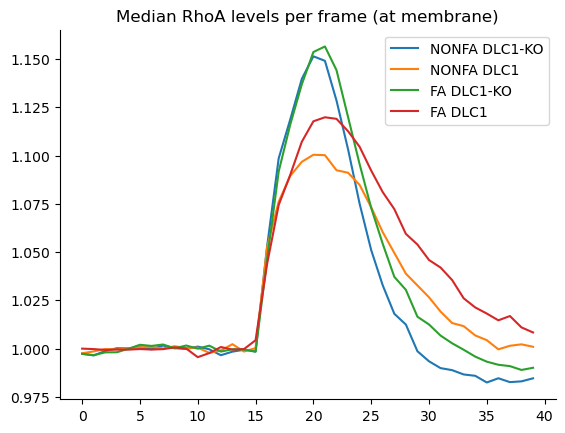

In [8]:
# Visualise the data
x = range(0, 40)
plt.plot(x, median_NONFA_KO_rhoa_per_frame, x, median_NONFA_rhoa_per_frame, x, median_FA_KO_rhoa_per_frame, x, median_FA_rhoa_per_frame)
plt.title("Median RhoA levels per frame (at membrane)")
plt.legend(["NONFA DLC1-KO", "NONFA DLC1", "FA DLC1-KO", "FA DLC1",])
plt.gca().spines[["top", "right"]].set_visible(False)

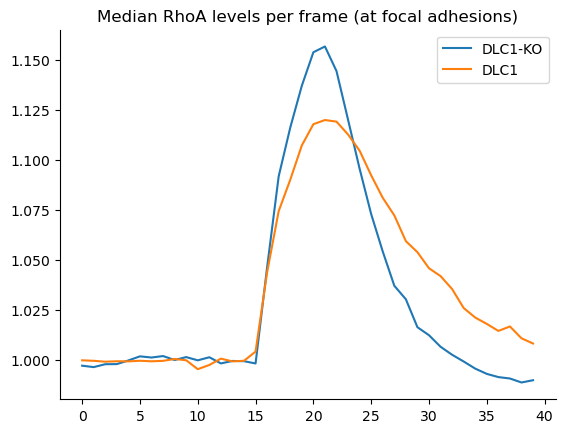

In [9]:
# Visualise the data
plt.plot(x, median_FA_KO_rhoa_per_frame, x, median_FA_rhoa_per_frame)
plt.title("Median RhoA levels per frame (at focal adhesions)")
plt.legend(["DLC1-KO", "DLC1"])
plt.gca().spines[["top", "right"]].set_visible(False)

In [25]:
# Export to txt files to import in Pluto notebook (Julia)
#median_FA_rhoa_per_frame.to_csv(os.path.join(data_dir, "median_rhoa_FA_dynamics.txt"), sep = " ", header = False)
#median_FA_KO_rhoa_per_frame.to_csv(os.path.join(data_dir, "median_rhoa_FA_KO_dynamics.txt"), sep = " ", header = False)
#median_NONFA_rhoa_per_frame.to_csv(os.path.join(data_dir, "median_rhoa_NONFA_dynamics.txt"), sep = " ", header = False)
#median_NONFA_KO_rhoa_per_frame.to_csv(os.path.join(data_dir, "median_rhoa_NONFA_KO_dynamics.txt"), sep = " ", header = False)

In [13]:
# Export to npy files to import with numpy (all variables in one file)
#t = np.arange(0, 40)
#np.savez(
#    "../Data/median_rhoa_dynamics.npz",
#    t = t,
    rhoa_FA = np.array(median_FA_rhoa_per_frame),
    rhoa_FA_KO = np.array(median_FA_KO_rhoa_per_frame),
    rhoa_NONFA = np.array(median_NONFA_rhoa_per_frame),
    rhoa_NONFA_KO = np.array(median_NONFA_KO_rhoa_per_frame)
)

#### 2: Smooth and augment the data by adding interpolation points

In [10]:
from scipy import interpolate

In [38]:
tck = interpolate.splrep(x, median_FA_rhoa_per_frame, s = 0.0003)
interpol_FA_rhoa_f = interpolate.BSpline(*tck)(x)
tck_KO = interpolate.splrep(x, median_FA_KO_rhoa_per_frame, s = 0.0001)
interpol_FA_KO_rhoa_f = interpolate.BSpline(*tck_KO)(x)

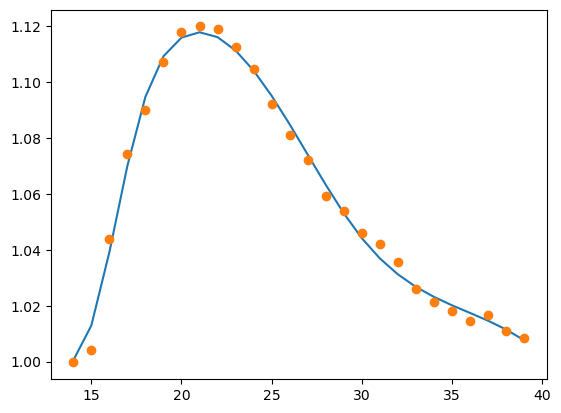

In [39]:
plt.plot(x[14:], interpol_FA_rhoa_f[14:], x[14:], median_FA_rhoa_per_frame[14:], "o")